In [1]:
import sys
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
physical_device = tf.config.experimental.list_physical_devices('GPU')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
GPU is available


In [2]:
from matplotlib import pyplot as plt
import pathlib

## create train and validation datasets
DB_PATH = "/content/drive/MyDrive/100daysofML/fashiondb/images"
BUFFER_SIZE = 10000
BATCH_SIZE = 128
IMG_WIDTH = 128
IMG_HEIGHT = 128

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
# dataset = tf.data.Dataset.list_files(DB_PATH+'/*.jpg')



In [3]:
dataset = tf.data.Dataset.list_files(DB_PATH+'/*.jpg')

In [5]:
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)

35568
8892


FileExistsError: ignored

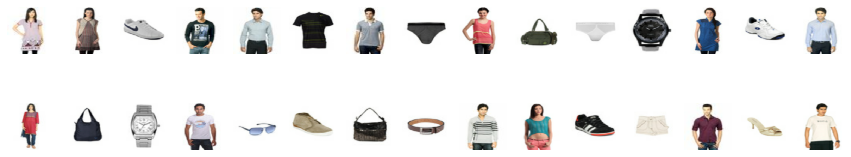

In [6]:
#image_batch = next(iter(train_ds))

plt.figure(figsize=(15, 5))
for images,targets in val_ds.take(1):
    for i in range(30):
        ax = plt.subplot(3, 15, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.axis("off")

import os
os.mkdir("Images")
plt.savefig("/Images/Visualizations.jpg")

In [7]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

latent_dim = 256  # Number of latent dimension parameters

input_img = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img)
x = BatchNormalization()(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim, kernel_initializer='zeros',bias_initializer='zeros')(x)

(None, 16, 16, 4)


In [8]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

encoder = Model(input_img,z)

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(4096, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
x = Reshape((8,8,64))(x)

x = Conv2DTranspose(32, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(16, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(8, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(3, (3, 3),strides= 2, padding='same', activation='sigmoid')(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
pred = decoder(z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 intermediate_decoder (Dense  (None, 4096)             1052672   
 )                                                               
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                           

In [10]:
from tensorflow.keras.metrics import binary_crossentropy

def vae_loss(x, pred):
    x = K.flatten(x)
    pred = K.flatten(pred)
    # Reconstruction loss
    #reconst_loss = 100 * binary_crossentropy(x, pred)
    reconst_loss = 1000*K.mean(K.square(x - pred))
    
    # KL divergence
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    
    return (reconst_loss + kl_loss)

In [11]:
# VAE model statement
vae = Model(input_img,pred)
vae.add_loss(vae_loss(input_img,pred))
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=None)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Epoch 1/5
278/278 [==============================] - 3170s 8s/step - loss: 88.0065 - val_loss: 55.9606
Epoch 2/5
278/278 [==============================] - 833s 2s/step - loss: 30.7650 - val_loss: 85.3324
Epoch 3/5
278/278 [==============================] - 251s 693ms/step - loss: 19.5682 - val_loss: 15.6701
Epoch 4/5
278/278 [==============================] - 143s 425ms/step - loss: 15.3047 - val_loss: 14.9152
Epoch 5/5
278/278 [==============================] - 126s 381ms/step - loss: 13.1713 - val_loss: 12.3959


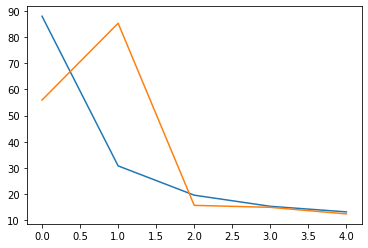

In [13]:
from keras.callbacks import EarlyStopping
from os import path

# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

if(path.exists("/checkpoints")):
    vae.load_weights("/checkpoints/vae")
else:
    history = vae.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping],verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    vae.save_weights("/checkpoints/vae")